In [754]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer
import enchant
import matplotlib as mpl
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import datetime as dt #datetime for timeseries support
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import spacy
from spacy.lang.en import English
from itertools import islice
from spacy_ngram import NgramComponent
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import gensim
import emoji
import ast
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part A - Getting the data with API

In [ ]:
api_key='private key :)'

In [ ]:
cat_lst=['Music','Movies']

In [ ]:
response

In [ ]:
def get_youtube_videos(api_key, category, max_results=50):
    youtube = build('youtube', 'v3', developerKey=api_key)
    videos = []
    for cat in category:
        request = youtube.search().list(part='snippet',q=cat,maxResults=max_results)
        response = request.execute()
        for item in range(len(response['items'])):
            if response['items'][item]['id']['kind'] == 'youtube#video':
                key= response['items'][item]['id']['videoId']
            elif response['items'][item]['id']['kind'] == 'youtube#channel':
                key= response['items'][item]['id']['channelId']
            videos.append({
            'Id': key,
            'title': response['items'][item]['snippet']['title'],
            'date': response['items'][item]['snippet']['publishedAt']
                        })
        while 'nextPageToken' in response:
            next_page_token = response['nextPageToken']
            request = youtube.search().list(
               part='snippet',
              q=cat,
              maxResults=max_results,
              pageToken=next_page_token
            )
            response = request.execute()
            for item in range(len(response['items'])):
                if response['items'][item]['id']['kind'] == 'youtube#video':
                    key= response['items'][item]['id']['videoId']
                elif response['items'][item]['id']['kind'] == 'youtube#channel':
                    key= response['items'][item]['id']['channelId']
                videos.append({
                    'Id': key,
                    'title': response['items'][item]['snippet']['title'],
                    'date': response['items'][item]['snippet']['publishedAt']
                    })
                    
    df = pd.DataFrame(videos)

    return df

df = get_youtube_videos(api_key, category=cat_lst)




In [ ]:
df

In [ ]:
df=df.drop_duplicates()


In [ ]:
df

In [ ]:
def get_description(api_key, id):
    try:
        youtube = build('youtube', 'v3', developerKey=api_key)
        request = youtube.videos().list(part='snippet',id=id)
        response = request.execute()
        return response['items'][0]['snippet']['description']
    except:
        return ""



In [ ]:
df['description'] = df['Id'].apply(lambda x: get_description(api_key, x))


we will save the df as csv and the read it. we do it in order to not use request again.

In [ ]:
# Save the DataFrame as a CSV file
df.to_csv('Y_T_df.csv', index=False) 

# Start running from here

In [1213]:
df = pd.read_csv('Y_T_df.csv') 


In [1214]:
df

,Id,title,date,description
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18T08:40:05Z,"Relaxing Music For Stress Relief, Anxiety and ..."
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18T13:49:38Z,► Music and Video Copyright belongs to @Praise...
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03T09:00:37Z,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18T08:51:47Z,Enjoy our latest relaxing music live stream: y...
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21T13:39:33Z,Composer: OZODA\nLyrics: OZODA\nArrangement: D...
...,...,...,...,...
1274,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17T21:12:46Z,Please Subscribe my YouTube channel.\n\n\n\n\n...
1275,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17T20:42:16Z,Please Subscribe my YouTube channel.\n\n\n\n\n...
1276,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17T11:11:12Z,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...
1277,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19T18:10:02Z,Click here 👇🏿\nDarkness Lurks Every Corner \nh...


## Part B - check the data

In [1215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           1279 non-null   object
 1   title        1279 non-null   object
 2   date         1279 non-null   object
 3   description  1165 non-null   object
dtypes: object(4)
memory usage: 40.1+ KB


In [1216]:
df.iloc[np.where(df['description'].isnull()==True)]

C:\Users\user\anaconda\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,Id,title,date,description
30,hAQcodpwsIA,IS THIS THE HOTTEST NEW ROCKSTAR OF 2023?! #mu...,2023-05-26T19:12:49Z,NaN
68,Q2O0BePaLSw,"Lobo, Frank Sinatra, Perry Como, Carpenters, T...",2023-05-05T11:00:30Z,NaN
94,LRpE1F854tM,Love Songs ~ Kaash Paige #spedup #music #viral...,2023-03-20T23:01:32Z,NaN
184,5lSGFVLfC78,~Kaash Paige~ ~Love Songs~ lyrics,2023-04-02T17:50:25Z,NaN
250,YM_l3wlDbTQ,Top 10 Lata Mangeshkar songs romantic songs ❤️...,2022-09-29T13:41:52Z,NaN
...,...,...,...,...
1203,C0_hkesZ1Xk,#trendingmovies #trending #movies #movieexplai...,2024-03-18T01:47:51Z,NaN
1210,0aDRDFlHgu8,بيهجم عليهم العناكب #movie #movies #ملخص_فيلم ...,2024-03-17T12:20:59Z,NaN
1225,UCGBzBkV-MinlBvHBzZawfLQ,Movie Central,2016-10-04T04:11:37Z,NaN
1231,UCBOmfqgTZi7yDp4-3Lr_3lA,Shemaroo Movies,2011-03-01T09:00:12Z,NaN


In [1217]:
# we will use functions on description column so we will enter the title where description is null
df['description'] = df['description'].fillna("")


In [1218]:
#maybe we will use date later. so we going to do date time

df['date'] = df['date'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))


In [1219]:
df['title&description'] = df.apply(lambda row: row['title'] + ' ' + row['description'], axis=1)


In [1220]:
df

,Id,title,date,description,title&description
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18 08:40:05,"Relaxing Music For Stress Relief, Anxiety and ...","Relaxing Music For Stress Relief, Anxiety and ..."
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18 13:49:38,► Music and Video Copyright belongs to @Praise...,Best Praise and Worship Songs 2023 ✝️ Nonstop...
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03 09:00:37,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18 08:51:47,Enjoy our latest relaxing music live stream: y...,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel..."
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21 13:39:33,Composer: OZODA\nLyrics: OZODA\nArrangement: D...,Ozoda - Ko&#39;k jiguli (Official Music Vide...
...,...,...,...,...,...
1274,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17 21:12:46,Please Subscribe my YouTube channel.\n\n\n\n\n...,3 Movies From My Big Fat Greek Wedding Flim Fr...
1275,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17 20:42:16,Please Subscribe my YouTube channel.\n\n\n\n\n...,2 Movies of The Evil Dead Flim Franchise. Plea...
1276,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17 11:11:12,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...,Scene 👀 #hollywoodmovie #englishmovie #moviecl...
1277,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19 18:10:02,Click here 👇🏿\nDarkness Lurks Every Corner \nh...,A hilarious and outrageous comedy video #movie...


In [1221]:
def text_preprocess(data):
    data = data.lower()
    data = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*, ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"", data)
    data = data.replace("|","").replace(" "," ").replace(";"," ").replace('\n',' ').replace('\t',' ')
    data = re.sub(r'[?|!|\'|"|,|#|-|@|(|)|$|%|^|&|*|+|_|=|,|<|>]', " ", data)
    data=re.sub(r'[^\x00-\x7F]+', '', data)
    data = data.replace(": "," ").replace("-"," ").replace(" :"," ")
    data = data.strip() 
    data = re.sub(r'\s+', ' ', data) 
    return data

In [1222]:
def get_emoji(row):
    emoji_list = row
    emojis = []
    for text in emoji_list:
        for character in text:
            if character in emoji.EMOJI_DATA:
                emojis.append(character)
    return emojis


In [1223]:
df['emoji'] = df['title&description'].apply(lambda x: get_emoji(x))


In [1224]:
df['emoji'][0]

['🎹', '🌞', '✔']

In [1225]:
df['title&description']=df['title&description'].apply(lambda x: text_preprocess(x))

In [1226]:
df['title&description'][0]

'relaxing music for stress relief anxiety and depressive states heal mind body and soul relaxing music for stress relief anxiety and depressive states heal mind body and soul music to sleep deeply and rest the mind relaxing and calm music to sleep. to stay calm and relieve stress after a hard day at work turn on soothing music. by listening to relaxing music you can reduce stress hormones in the body. it helps the body fight the symptoms of prolonged stress. we are a music label that does everything possible to help you feel calmer and happier with music. music has no barriers so no matter who you are or where you come from these beautiful beats are made for you. join the journey to find your inner peace and brighten your day. helios4k relax sleepmusic more soothing music on spotify playlist for contact and submit music relax wondermusic.us all rights belong to their respective owners. this video was given a special license directly from the artists and the right holders.'

In [1227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Id                 1279 non-null   object        
 1   title              1279 non-null   object        
 2   date               1279 non-null   datetime64[ns]
 3   description        1279 non-null   object        
 4   title&description  1279 non-null   object        
 5   emoji              1279 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 60.1+ KB


In [1228]:
df.head()

,Id,title,date,description,title&description,emoji
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18 08:40:05,"Relaxing Music For Stress Relief, Anxiety and ...",relaxing music for stress relief anxiety and d...,"[🎹, 🌞, ✔]"
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18 13:49:38,► Music and Video Copyright belongs to @Praise...,best praise and worship songs 2023 nonstop chr...,"[✝, 🔻, 📌, 📌, 📌, 📌]"
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03 09:00:37,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...,creepy nutsbling bang bang born tv anime mashl...,[©]
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18 08:51:47,Enjoy our latest relaxing music live stream: y...,relaxing music 24/7 sleep music stress relief ...,[🔴]
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21 13:39:33,Composer: OZODA\nLyrics: OZODA\nArrangement: D...,ozoda ko 39 k jiguli official music video 2024...,"[▪, ▪]"


## Part C - NLP 

### Spacy NLP process

In [1229]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def process_description_enhanced(text):
    doc = nlp(text)
    #  Stop word removal + Lemmatization 
    tokens = []
    for token in doc:
      if not token.is_stop and not token.is_punct:
        if token.pos_ in ['NOUN', 'VERB']:
          tokens.append(token.lemma_)  
        else:
          tokens.append(token.text)
    text = " ".join(tokens)
    doc = nlp(text)  
    tokens = [token.text for token in doc if not token.ent_type_]  
    text = " ".join(tokens)
    return text


In [1230]:
df['processed'] = df['title&description'].apply(lambda x: process_description_enhanced(x))


In [1231]:
df['processed'][0]

'relax music stress relief anxiety depressive state heal mind body soul relax music stress relief anxiety depressive state heal mind body soul music sleep deeply rest mind relax calm music sleep stay calm relieve stress work turn soothe music listen relax music reduce stress hormone body help body fight symptom prolong stress music label possible help feel happier music music barrier matter come beautiful beat join journey find inner peace brighten day helios4k relax sleepmusic soothing music spotify playlist contact submit music relax right belong respective owner video give special license directly artist right holder'

### Calculating emotions from the text

In [726]:
from nrclex import NRCLex
def emotions(text):
    lex = NRCLex(text) 
    raw_scores = lex.raw_emotion_scores
    emotion_scores = {}
    for emotion, score in raw_scores.items():
        emotion_scores[emotion] = score / len(text.split())
    return emotion_scores

In [727]:
df['emotions'] = df['processed'].apply(lambda x: emotions(x))


### Looking at videos with no emotins

In [728]:
df_known = df.loc[df['emotions'] !={}]
df_unknown = df.loc[df['emotions'] =={}]


In [729]:
df_known.to_csv('df_known.csv', index=False) 
df_unknown.to_csv('df_unknown.csv', index=False) 



Saving the data after the NLP

In [1141]:
df_known = pd.read_csv('df_known.csv') 
df_unknown = pd.read_csv('df_unknown.csv') 

In [1242]:
df_unknown['title&description']=df_unknown['title'].apply(lambda x: text_preprocess(x))

In [1143]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def emoji_to_emotions(emoji):
    emoji = " ".join(emoji)
    if emoji!='':
        analyzer = SentimentIntensityAnalyzer()
        sentiment = analyzer.polarity_scores(emoji)
        return sentiment
    else:
        return ''


In [1144]:
df_unknown['emoji_grade']=df_unknown['emoji'].apply(lambda x: emoji_to_emotions(x))

In [1262]:
df_unknown

,Id,title,date,description,title&description,emoji,processed,emotions,emoji_grade
0,6dNh0Vp6JH8,IF YOU KNOW THESE SONGS YOU’RE HEARTBROKEN😭 #s...,2022-03-28 20:54:11,NaN,if you know these songs youre heartbroken shorts,['😭'],know song heartbroken short,{},"{'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'comp..."
1,8n9T31oNV6s,THE BEST SONG EVER 2023!,2023-01-06 01:00:02,NaN,the best song ever 2023,[],best song,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Sv5yCzPCkv8,SZA - Snooze (Audio),2022-12-09 05:00:20,SZA’s New Album “SOS” // Available Everywhere ...,sza snooze audio,[],sza snooze audio sza new album available liste...,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,LrvfQWvN85Y,သင်္ကြန်သီချင်းကောင်းများစုစည်းမှု Myanmar Thi...,2023-03-16 22:30:03,သင်္ကြန်သီချင်းကောင်းများစုစည်းထားသော ဗွီဒီယို...,myanmar thingyan songs collection thingyan,[],myanmarwaterfestival,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,UDVUV39YAcE,Disturbed - The Sound Of Silence (Lyrics),2024-03-10 14:30:17,Disturbed - The Sound Of Silence (Lyrics)\n\nD...,disturbed the sound of silence lyrics,[],disturb sound silence lyric disturb sound sile...,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...,...,...,...
56,ly-OZ7AMywU,Savyasachi Hindi Dubbed Movie | Naga Chaitanya...,2023-02-11 12:33:36,Savyasachi Hindi Dubbed Movie | Naga Chaitanya...,savyasachi hindi dubbed movie naga chaitanya n...,[],agerwal agerwal,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
57,dwkrkSIO7Y4,Sniper US Vs Sniper Iraq #movieclip #movies #s...,2024-03-17 13:22:09,Sniper US Vs Sniper Iraq #movieclip #movies #s...,sniper us vs sniper iraq movieclip movies shor...,[],sniper vs sniper movieclip movie short sniper ...,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
58,0aDRDFlHgu8,بيهجم عليهم العناكب #movie #movies #ملخص_فيلم ...,2024-03-17 12:20:59,NaN,movie movies moviereview shorts,[],movie movie moviereview short,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
59,UCGBzBkV-MinlBvHBzZawfLQ,Movie Central,2016-10-04 04:11:37,NaN,movie central,[],movie central,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


### As you can see, extracting emotions from emojis is not efficient enough for this data (there aren't many emojis). In order to successfully extract emotions from this data, it is necessary to split connected words into words that exist in the language. It is a long and complex process and we preferred not to delve into it at this stage because there is not much data in the data. Therefore we decided to continue the project only with df_known.

### Finding emotions by emojis

In [1263]:
df_known.loc[:, 'emoji_grade'] = df_known['emoji'].apply(lambda x: emoji_to_emotions(x))


### MinMaxScaler - We do this to highlight main emotions and de-emphasize marginal emotions in each video

In [1265]:
def scaler(text):
    if type(text) != dict:
        text = ast.literal_eval(text)
    try:            
        text = pd.DataFrame.from_dict(text, orient='index', columns=['score'])
        scaler = MinMaxScaler()
        text['score'] = scaler.fit_transform(text.apply(pd.Series))
        emotions_dict = text.to_dict()
        return emotions_dict['score']
    except:
        return ""

In [1266]:
df_known.loc[:, 'scaled_emotions'] = df_known['emotions'].apply(lambda x: scaler(x))


In [1267]:
df_known

,Id,title,date,description,title&description,emoji,processed,emotions,emoji_grade,scaled_emotions,rank_emotions
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18 08:40:05,"Relaxing Music For Stress Relief, Anxiety and ...",relaxing music for stress relief anxiety and d...,"['🎹', '🌞', '✔']",relax music stress relief anxiety depressive s...,"{'joy': 0.2, 'positive': 0.28421052631578947, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.6923076923076924, 'positive': 0.9999...","(0.0, 0.0)"
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18 13:49:38,► Music and Video Copyright belongs to @Praise...,best praise and worship songs 2023 nonstop chr...,"['✝', '🔻', '📌', '📌', '📌', '📌']",best praise worship song nonstop song time pra...,"{'joy': 0.32653061224489793, 'positive': 0.346...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.9375, 'positive': 1.0000000000000002...","(0.0, 0.0)"
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03 09:00:37,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...,creepy nutsbling bang bang born tv anime mashl...,['©'],anime mashle collaboration music video bbbb bl...,"{'joy': 0.02912621359223301, 'positive': 0.077...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.16666666666666669, 'positive': 1.0, ...","(0.0, 0.0)"
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18 08:51:47,Enjoy our latest relaxing music live stream: y...,relaxing music 24/7 sleep music stress relief ...,['🔴'],relax music sleep music stress relief music sp...,"{'joy': 0.3020408163265306, 'positive': 0.4265...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.7024390243902439, 'positive': 1.0, '...","(0.0, 0.0)"
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21 13:39:33,Composer: OZODA\nLyrics: OZODA\nArrangement: D...,ozoda ko 39 k jiguli official music video 2024...,"['▪', '▪']",official music video composer ozoda lyric ozod...,"{'trust': 0.047619047619047616, 'joy': 0.04761...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'trust': 0.0, 'joy': 0.0, 'positive': 1.0, 's...","(0.0, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...
1213,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17 21:12:46,Please Subscribe my YouTube channel.\n\n\n\n\n...,3 movies from my big fat greek wedding flim fr...,[],movie big fat wedding flim franchise subscribe...,"{'disgust': 0.015873015873015872, 'negative': ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'disgust': 0.0, 'negative': 0.0, 'sadness': 0...","(0.0, 0.0)"
1214,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17 20:42:16,Please Subscribe my YouTube channel.\n\n\n\n\n...,2 movies of the evil dead flim franchise. plea...,[],movie evil dead flim franchise subscribe youtu...,"{'anger': 0.016129032258064516, 'disgust': 0.0...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'anger': 0.0, 'disgust': 0.0, 'fear': 0.0, 'n...","(0.0, 0.0)"
1215,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17 11:11:12,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...,scene hollywoodmovie englishmovie movieclips f...,"['👀', '❤', '❤']",scene hollywoodmovie englishmovie movieclips f...,"{'anticipation': 0.1774193548387097, 'joy': 0....","{'neg': 0.0, 'neu': 0.607, 'pos': 0.393, 'comp...","{'anticipation': 0.75, 'joy': 0.66666666666666...","(0.0, 0.0)"
1216,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19 18:10:02,Click here 👇🏿\nDarkness Lurks Every Corner \nh...,a hilarious and outrageous comedy video movie ...,"['👇', '🏿', '👇', '🏿', '🔔']",hilarious outrageous comedy video movie action...,"{'joy': 0.05714285714285714, 'positive': 0.114...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.25, 'positive': 0.75, 'surprise': 0....","(0.0, 0.0)"


### Changing the shape of the data to contain the emotions in columns and their score for each video

In [1268]:
def fill_df(row,i):
    for key,val in row.items():
        if key == i:
            return val


In [1269]:
emotions_lst=[]
for row in test['scaled_emotions']:
    for key in row:
        if key not in emotions_lst:
            emotions_lst.append(key)
emotions_lst.insert(0, 'Id')
emotions_df = pd.DataFrame(columns=emotions_lst)


In [1270]:
for i in emotions_lst:
    emotions_df[i]=df_known['scaled_emotions'].apply(lambda x: fill_df(x,i))
emotions_df=emotions_df.fillna(0.0)
emotions_df['Id']=df_known['Id']
emotions_df

,Id,joy,positive,sadness,negative,anger,anticipation,fear,trust,disgust,surprise
0,v4KXWsMw8Fc,0.692308,1.000000,0.538462,0.461538,0.115385,0.153846,0.115385,0.192308,0.000000,0.000000
1,NgGJaXDC0wU,0.937500,1.000000,0.187500,0.000000,0.000000,0.437500,0.187500,0.812500,0.000000,0.000000
2,mLW35YMzELE,0.166667,1.000000,0.500000,0.000000,0.833333,0.000000,0.833333,0.166667,0.000000,0.000000
3,BxPhT3mVVQw,0.702439,1.000000,0.521951,0.043902,0.000000,0.146341,0.004878,0.175610,0.000000,0.063415
4,h8Cq1BwdTsg,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1213,ZygQeQ4paLc,0.000000,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1214,qAPsrv5qFwc,0.000000,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1215,HUrsuH5KRJM,0.666667,1.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.583333,0.000000,0.333333
1216,Wwd1sfHSwcQ,0.250000,0.750000,0.000000,1.000000,0.500000,0.250000,0.250000,0.000000,0.000000,0.500000


# Clustering

# Hierarchical clustering


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Ward linkage:
[3 3 3 ... 3 2 2]

Number of clusters based on threshold: 3
SSE for Ward linkage: 536.407147782932
Silhouette Score for Ward linkage: 0.3535530099139839
Calinski-Harabasz Score for Ward linkage: 373.3093214482945


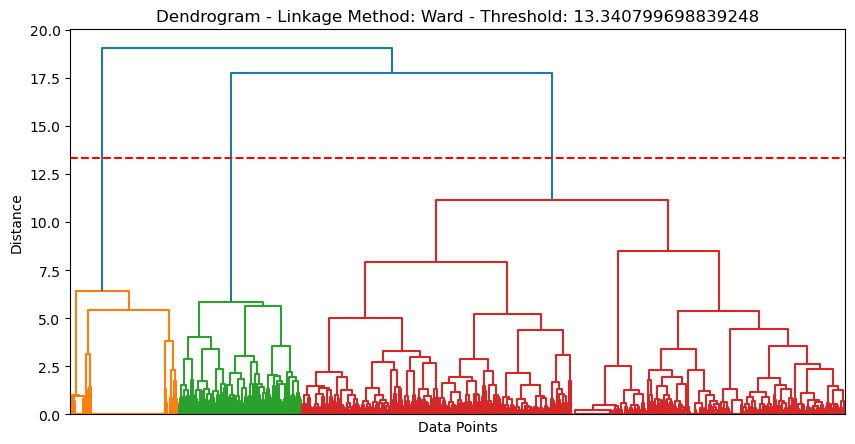

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Complete linkage:
[9 6 4 ... 3 9 7]

Number of clusters based on threshold: 9
SSE for Complete linkage: 323.17110847707414
Silhouette Score for Complete linkage: 0.1443478850315535
Calinski-Harabasz Score for Complete linkage: 142.8074509553792


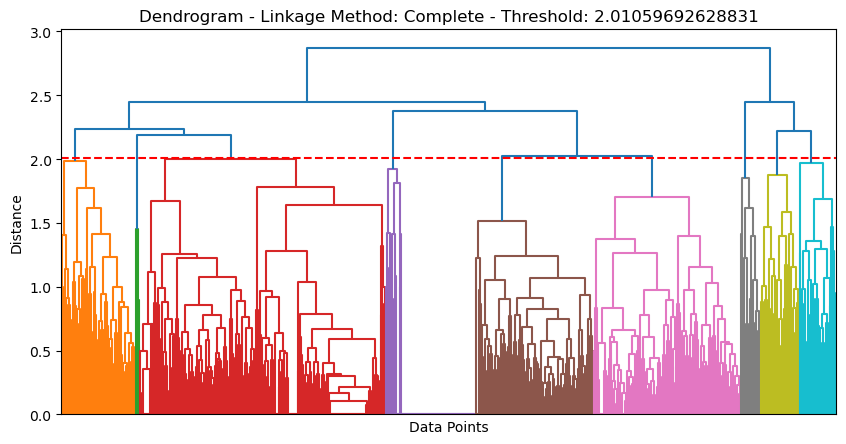

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Average linkage:
[6 6 6 ... 6 6 5]

Number of clusters based on threshold: 6
SSE for Average linkage: 386.9004385283905
Silhouette Score for Average linkage: 0.2793329327132849
Calinski-Harabasz Score for Average linkage: 39.860366820114756


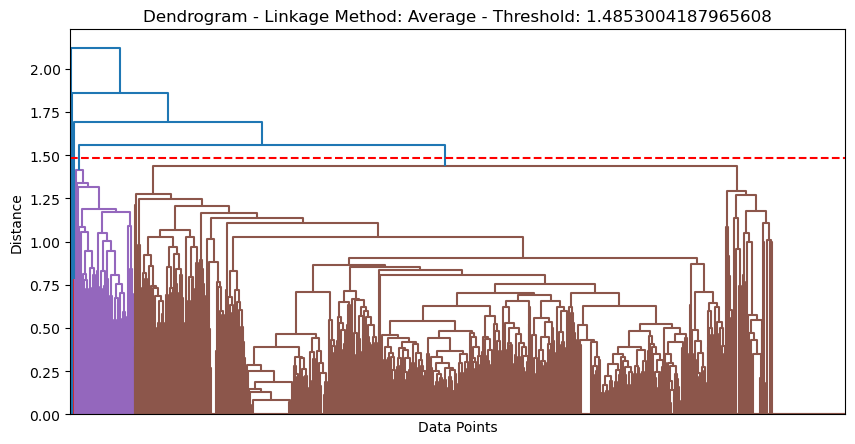

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Single linkage:
[3 3 3 ... 3 3 3]

Number of clusters based on threshold: 12
SSE for Single linkage: 290.15416172952615
Silhouette Score for Single linkage: 0.22209016893881953
Calinski-Harabasz Score for Single linkage: 26.107138665213885


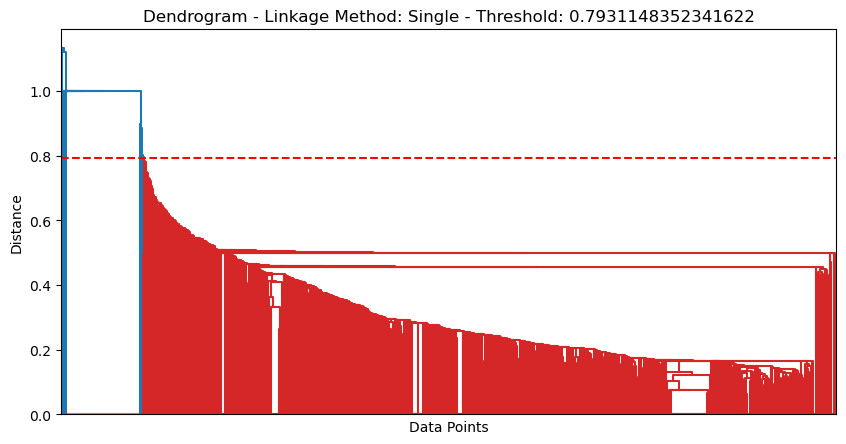

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Ward linkage:
[3 3 3 ... 3 2 2]

Number of clusters based on threshold: 3
SSE for Ward linkage: 536.407147782932
Silhouette Score for Ward linkage: 0.3535530099139839
Calinski-Harabasz Score for Ward linkage: 373.3093214482945


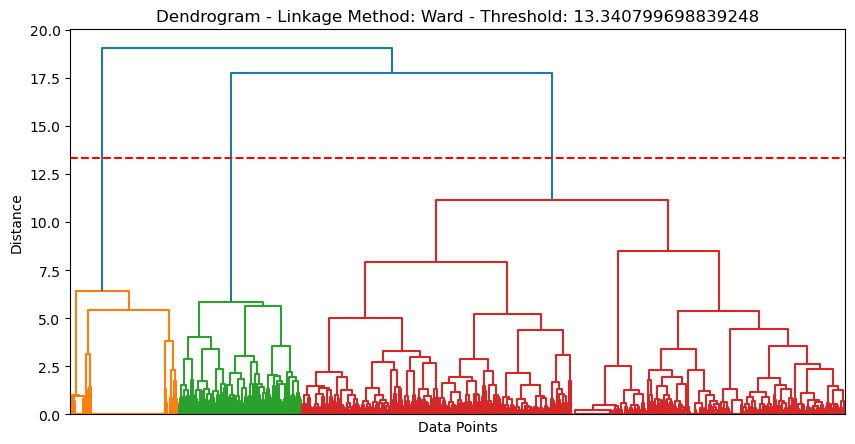

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Complete linkage:
[9 6 4 ... 3 9 7]

Number of clusters based on threshold: 9
SSE for Complete linkage: 323.17110847707414
Silhouette Score for Complete linkage: 0.1443478850315535
Calinski-Harabasz Score for Complete linkage: 142.8074509553792


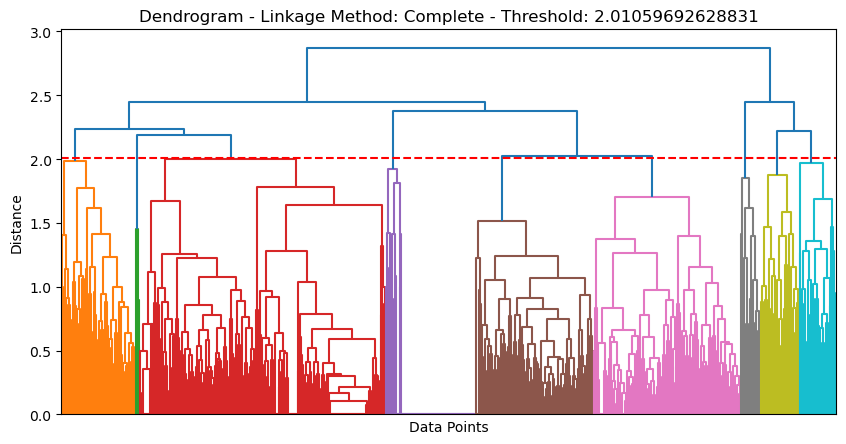

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Average linkage:
[6 6 6 ... 6 6 5]

Number of clusters based on threshold: 6
SSE for Average linkage: 386.9004385283905
Silhouette Score for Average linkage: 0.2793329327132849
Calinski-Harabasz Score for Average linkage: 39.860366820114756


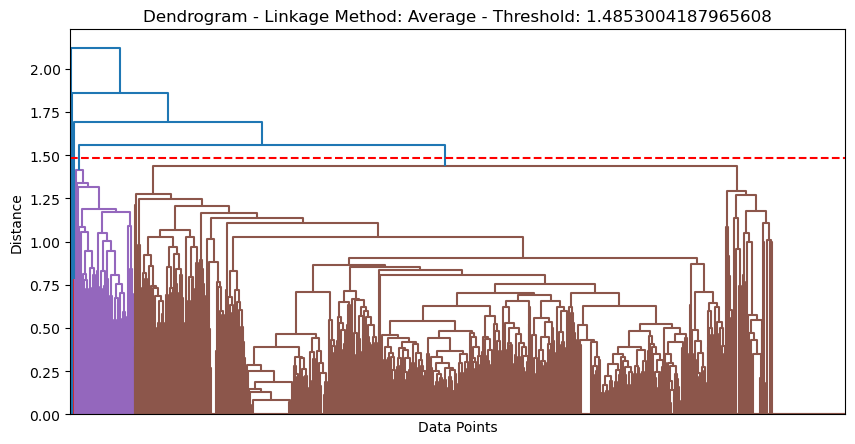

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Single linkage:
[3 3 3 ... 3 3 3]

Number of clusters based on threshold: 12
SSE for Single linkage: 290.15416172952615
Silhouette Score for Single linkage: 0.22209016893881953
Calinski-Harabasz Score for Single linkage: 26.107138665213885


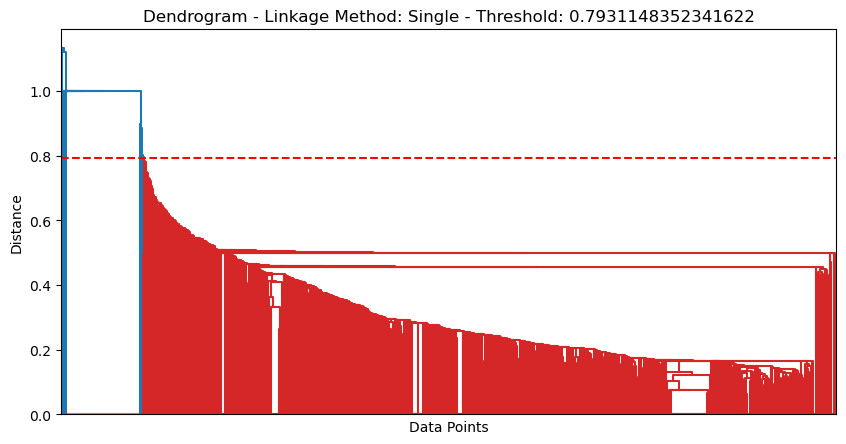

In [1556]:

def compare_agglomerative_clustering(data_frame):
    n_clusters_lst=[]
    result = []
    data_array = emotions_df.iloc[:,1:].values
    linkage_methods = ['ward', 'complete', 'average', 'single']

    for method in linkage_methods:
        Z = linkage(data_array, method)
        max_d = Z[-1, 2]
        threshold = 0.7 * max_d

        cluster_assignments = fcluster(Z, threshold, criterion='distance')
        n_clusters = len(set(cluster_assignments))

        # SSE Calculation
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_array) 
        sse = kmeans.inertia_

        # Silhouette Score Calculation
        silhouette_avg = silhouette_score(data_array, cluster_assignments)

        # Additional Metric
        calinski_harabasz = calinski_harabasz_score(data_array, cluster_assignments)

        print(f'Cluster labels using {method.capitalize()} linkage:\n{cluster_assignments}\n{"="*40}\n')
        print(f'Number of clusters based on threshold: {n_clusters}')
        print(f'SSE for {method.capitalize()} linkage: {sse}')
        print(f'Silhouette Score for {method.capitalize()} linkage: {silhouette_avg}')
        print(f'Calinski-Harabasz Score for {method.capitalize()} linkage: {calinski_harabasz}')
        n_clusters_lst.append(n_clusters)
        result.append((n_clusters,sse,silhouette_avg,calinski_harabasz,method))

        plt.figure(figsize=(10, 5))
        dendrogram(Z, labels=data_frame.index, orientation='top', leaf_rotation=90, leaf_font_size=8)
        plt.title(f'Dendrogram - Linkage Method: {method.capitalize()} - Threshold: {threshold}')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.axhline(y=threshold, color='r', linestyle='dashed')
        plt.show()
    return n_clusters_lst,result

n_clusters_lst= compare_agglomerative_clustering(emotions_df.iloc[:, 1:])[0]
results_lst=  compare_agglomerative_clustering(emotions_df.iloc[:, 1:])[1]  


In [1557]:
df_result= pd.DataFrame(results_lst,columns=['n_clusters' ,'SSE','Silhouette','Calinski-Harabasz' ,'linkage_methods'])
df_result


,n_clusters,SSE,Silhouette,Calinski-Harabasz,linkage_methods
0,3,536.407148,0.353553,373.309321,ward
1,9,323.171108,0.144348,142.807451,complete
2,6,386.900439,0.279333,39.860367,average
3,12,290.154162,0.222090,26.107139,single


In [1558]:
# possible clusters
n_clusters_lst

[3, 9, 6, 12]

## conclusions:
#### When you look at the table of results you can see that the clearly preferred option is ward linkage which divides into 3 groups.

# k-means clustering


## find values for n_clusters

### using heat map & corr & Using networkx

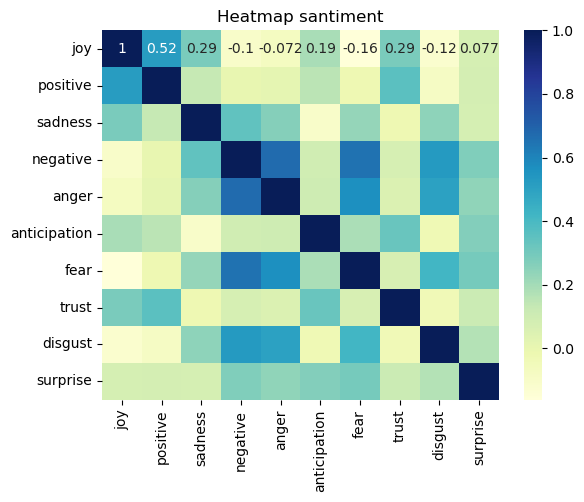

In [1274]:
import seaborn as sns
sns.heatmap(emotions_df.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.title("Heatmap santiment")
plt.show()

In [1275]:
treshold=0.3
# Find the correlation matrix
corr_matrix = emotions_df.iloc[:, 1:].corr()
# Sort the correlation matrix by absolute value of a column
for i in emotions_df.iloc[:, 1:].columns:
    sorted_corr_matrix = corr_matrix.sort_values(by=i, ascending=False)
    result=sorted_corr_matrix[i].iloc[np.where(sorted_corr_matrix[i]>treshold)].head(2)
    # Print the top correlations
    print("most related to",i,"are:\n\n",result,"\n")

most related to joy are:

 joy         1.000000
positive    0.520255
Name: joy, dtype: float64 

most related to positive are:

 positive    1.000000
joy         0.520255
Name: positive, dtype: float64 

most related to sadness are:

 sadness     1.000000
negative    0.344177
Name: sadness, dtype: float64 

most related to negative are:

 negative    1.000000
anger       0.670332
Name: negative, dtype: float64 

most related to anger are:

 anger       1.000000
negative    0.670332
Name: anger, dtype: float64 

most related to anticipation are:

 anticipation    1.000000
trust           0.327424
Name: anticipation, dtype: float64 

most related to fear are:

 fear        1.00000
negative    0.65101
Name: fear, dtype: float64 

most related to trust are:

 trust       1.000000
positive    0.357778
Name: trust, dtype: float64 

most related to disgust are:

 disgust     1.00000
negative    0.52922
Name: disgust, dtype: float64 

most related to surprise are:

 surprise    1.0
Name: surpr

In [1276]:
g1=('joy','positive')
g2=('positive','joy')
g3=('sadness','negative')
g4=('negative','anger')
g5=('anger','negative')
g6 = ("anticipation","trust")
g7= ("fear","negative")
g8 =("trust","positive")
g9 = ("disgust","negative")
g10=('surprise','surprise')

A low density (0.0317) and a low clustering coefficient (0.2) may indicate the absence of significant relationships between the nodes

### Use networkx in order to find emotions groups with high corr 

density: 0.17777777777777778
clustering AVG : 0.0


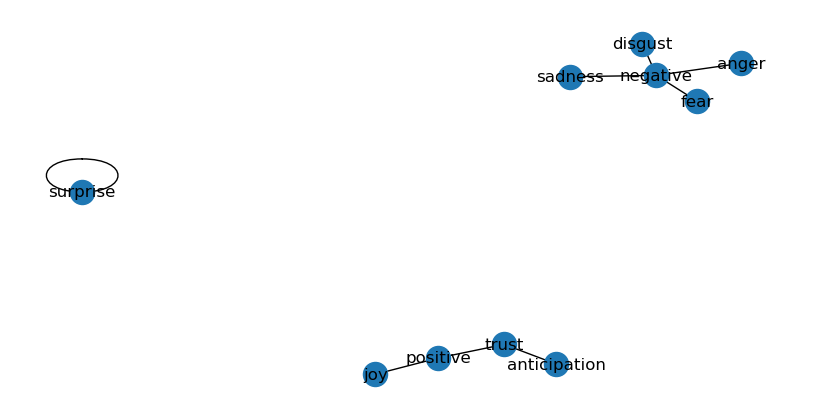

In [1459]:
import networkx as nx

emotions = emotions_df.iloc[:,1:-1].columns
edges=[g1,g2,g3,g4,g5,g6,g7,g8,g9,g10]
G = nx.Graph()
G.add_nodes_from(emotions)
G.add_edges_from(edges)
    
pos = nx.spring_layout(G)
density = nx.density(G)
average_clustering = nx.average_clustering(G)
print(f"density: {density}")
print(f"clustering AVG : {average_clustering}")
    
plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True)
plt.show()


### Choose hyperparameters for K-Means model

In [1285]:
k_means_df=emotions_df.copy()

In [1290]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, calinski_harabasz_score
sse_values = [] 
silhouette_values = [] 
calinski_harabasz_values = [] 
results_lst=[]
if 3 not in n_clusters_lst:
    n_clusters_lst.append(3)
distance_metrics = ['euclidean', 'manhattan']  
init_methods = ['random', 'k-means++'] 
max_iter_lst = [300, 500]
flag = False
for n_clusters in n_clusters_lst:
    for distance_metric in distance_metrics:
        for init_method in init_methods:
            for max_iter in max_iter_lst: 
                km_model = KMeans(n_clusters=n_clusters, 
                                  random_state=42,
                                  init=init_method,
                                  max_iter=max_iter, 
                                  n_init='auto',
                                  algorithm='auto') 
                if flag == False:
                    km_labels = km_model.fit_predict(k_means_df.iloc[:,1:])
                    k_means_df["cluster_label"] = kmeans.labels_
                    clustered_data = k_means_df.groupby("cluster_label")
                else:
                    km_labels = km_model.fit_predict(k_means_df.iloc[:,1:-1])
                    k_means_df["cluster_label"] = kmeans.labels_
                    clustered_data = k_means_df.groupby("cluster_label")
                flag = True
                sse = km_model.inertia_
                sse_values.append(sse)
                silhouette_avg = silhouette_score(k_means_df.iloc[:,1:], km_labels)
                silhouette_values.append(silhouette_avg)
                calinski_harabasz = calinski_harabasz_score(k_means_df.iloc[:,1:], km_labels)
                calinski_harabasz_values.append(calinski_harabasz) 
                results_lst.append((n_clusters,max_iter,init_method,distance_metric,sse,silhouette_avg,calinski_harabasz))

df_result_Kmeans= pd.DataFrame(results_lst,columns=['n_clusters','max_iter','init_method','distance_metric','SSE','Silhouette','Calinski-Harabasz'])
df_result_Kmeans

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\clu

,n_clusters,max_iter,init_method,distance_metric,SSE,Silhouette,Calinski-Harabasz
0,3,300,random,euclidean,536.407148,0.520630,1223.672644
1,3,500,random,euclidean,536.416216,0.520257,1220.250424
2,3,300,k-means++,euclidean,536.416216,0.520257,1220.250424
3,3,500,k-means++,euclidean,536.416216,0.520257,1220.250424
4,3,300,random,manhattan,536.416216,0.520257,1220.250424
5,3,500,random,manhattan,536.416216,0.520257,1220.250424
6,3,300,k-means++,manhattan,536.416216,0.520257,1220.250424
7,3,500,k-means++,manhattan,536.416216,0.520257,1220.250424
8,9,300,random,euclidean,324.789107,0.255369,449.316452
9,9,500,random,euclidean,324.789107,0.255369,449.316452


### It can be clearly seen from looking at the table of results that the hyperparameter that significantly affects the results is K, i.e. the final number of groups. There is a small advantage in scores even for random selection of the centers of the points so we will use these hyperparameters.

In [1562]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, calinski_harabasz_score
sse_values = [] 
silhouette_values = [] 
calinski_harabasz_values = [] 
results_lst=[]
n_clusters_lst = [2,3,6,12]
for n_clusters in n_clusters_lst:
    km_model = KMeans(n_clusters=n_clusters, init='random',random_state=42)
    km_labels = km_model.fit_predict(emotions_df.iloc[:,1:])
    sse = km_model.inertia_
    sse_values.append(sse)
    silhouette_avg = silhouette_score(emotions_df.iloc[:,1:], km_labels)
    silhouette_values.append(silhouette_avg)

    # Calinski-Harabasz Score Calculation
    calinski_harabasz = calinski_harabasz_score(emotions_df.iloc[:,1:], km_labels)
    calinski_harabasz_values.append(calinski_harabasz) 
    results_lst.append((n_clusters,sse,silhouette_avg,calinski_harabasz))
    print(f"k-means with {n_clusters} clusters:")
    print(f"SSE: {sse}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
df_result_Kmeans= pd.DataFrame(results_lst,columns=['n_clusters' ,'SSE','Silhouette','Calinski-Harabasz'])
df_result_Kmeans

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 2 clusters:
SSE: 702.1574751816532
Silhouette Score: 0.29878476629967526
Calinski-Harabasz Score: 326.20360797083566


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 3 clusters:
SSE: 536.416215824054
Silhouette Score: 0.3619037224296136
Calinski-Harabasz Score: 401.02588134939606


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 6 clusters:
SSE: 386.9004385283905
Silhouette Score: 0.27163766069886547
Calinski-Harabasz Score: 315.5253019258497


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 12 clusters:
SSE: 290.0028383371471
Silhouette Score: 0.2499050392764336
Calinski-Harabasz Score: 227.0263640113189


,n_clusters,SSE,Silhouette,Calinski-Harabasz
0,2,702.157475,0.298785,326.203608
1,3,536.416216,0.361904,401.025881
2,6,386.900439,0.271638,315.525302
3,12,290.002838,0.249905,227.026364


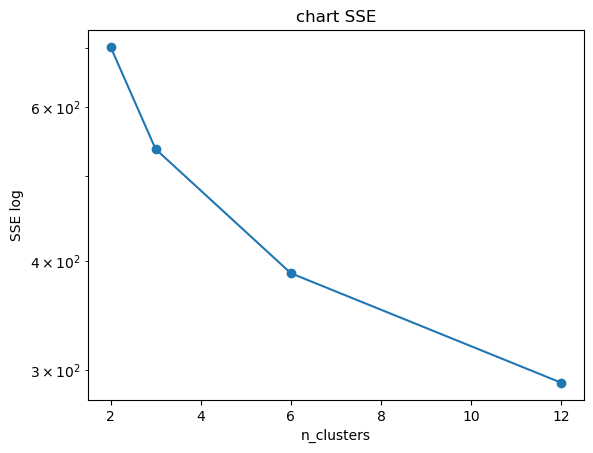

In [1563]:
plt.plot(n_clusters_lst, sse_values,marker='o')
plt.xlabel("n_clusters")
plt.ylabel("SSE log")
plt.yscale("log")
plt.title("chart SSE")
plt.show()


## conclusions
### We got the best result for 3 clusters. You can see an "elbow" in the graph and a significantly higher silhouette score than the other options.

In [1606]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(emotions_df.iloc[:,1:])
emotions_df["cluster_label"] = kmeans.labels_
clustered_data = emotions_df.groupby("cluster_label")
print(clustered_data.size())

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster_label
0    855
1    171
2    192
dtype: int64


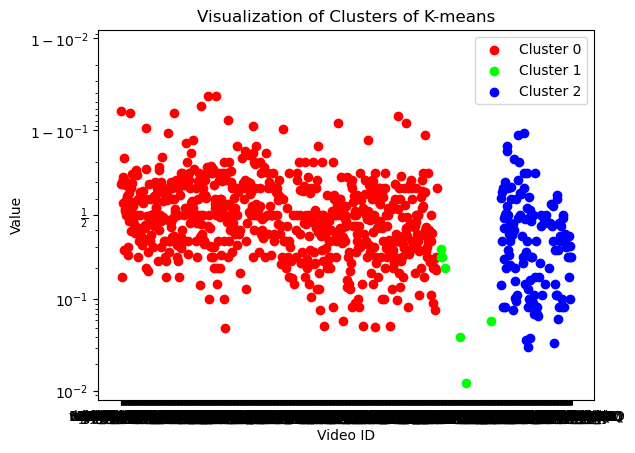

<Figure size 3000x1000 with 0 Axes>

In [1608]:
colors = ['#ff0000', '#00ff00', '#0000ff']
for i in range(n_clusters):
    plt.scatter(clustered_data.get_group(i).iloc[:, 0], clustered_data.get_group(i).iloc[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("Visualization of Clusters of K-means")
plt.xlabel("Video ID")
plt.ylabel("Value")
plt.yscale("logit")
plt.legend()
plt.figure(figsize=(30, 10))

plt.show()

# DBSCAN

Silhouette Score: -0.03962996372356883
Calinski-Harabasz Score: 66.62587386692238


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


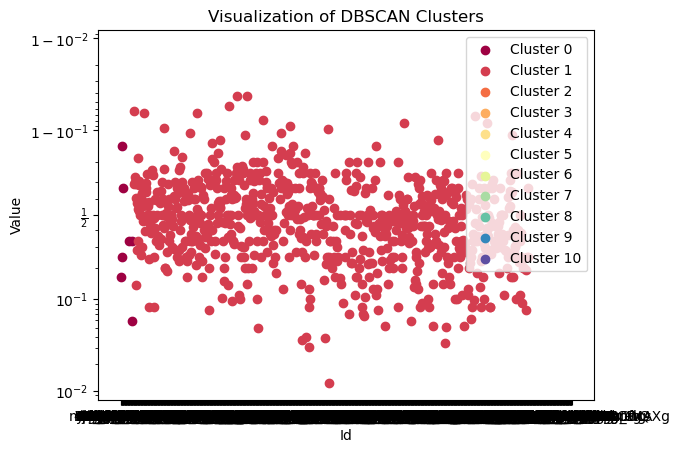

Silhouette Score: -0.01097902310127669
Calinski-Harabasz Score: 72.15555660881309


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


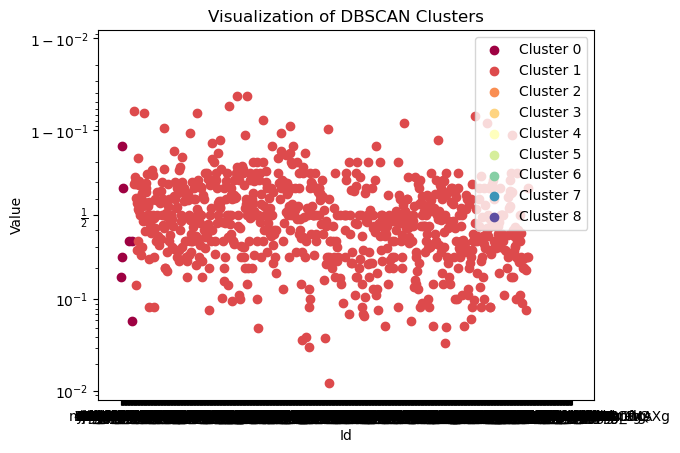

Silhouette Score: -0.0030634631532744177
Calinski-Harabasz Score: 106.05852848704367


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


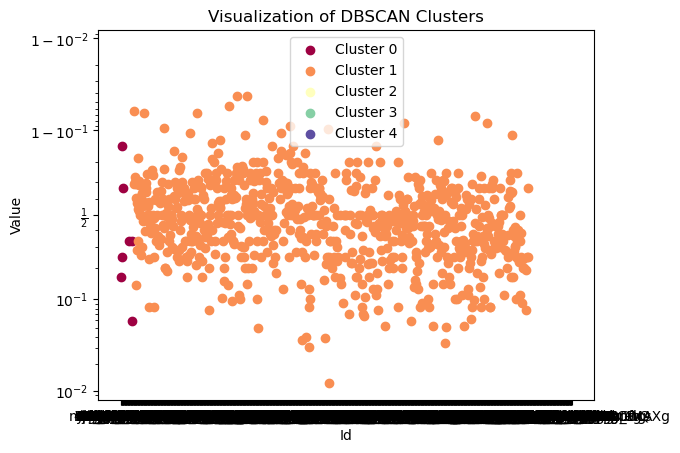

Silhouette Score: 0.2963201803242456
Calinski-Harabasz Score: 126.3617282535426


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


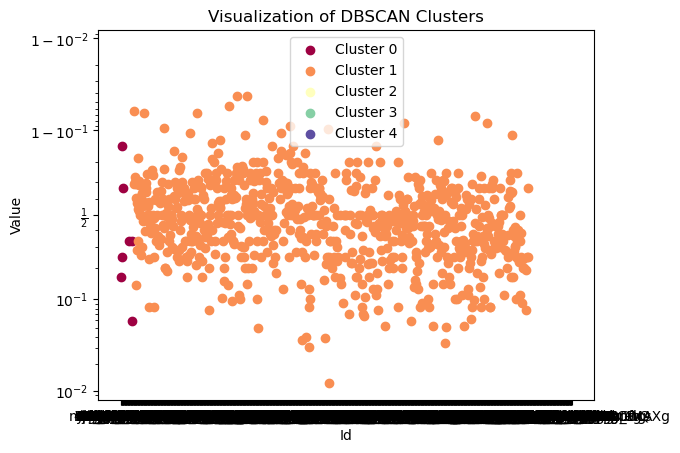

Silhouette Score: 0.3259080647929672
Calinski-Harabasz Score: 277.6034290394758


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


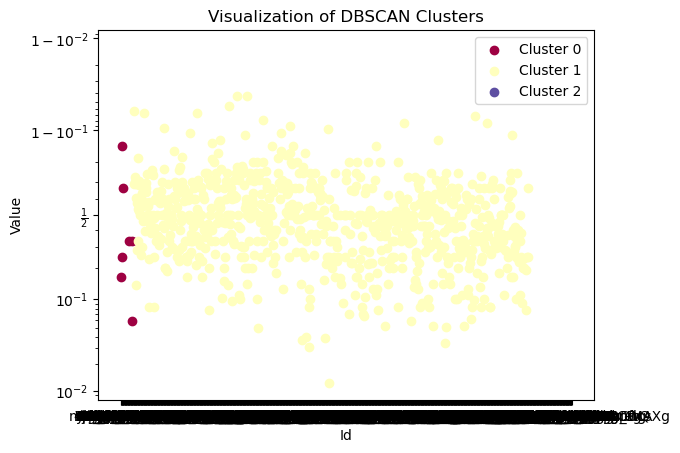

Silhouette Score: 0.3372259805735837
Calinski-Harabasz Score: 230.07325349013607


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


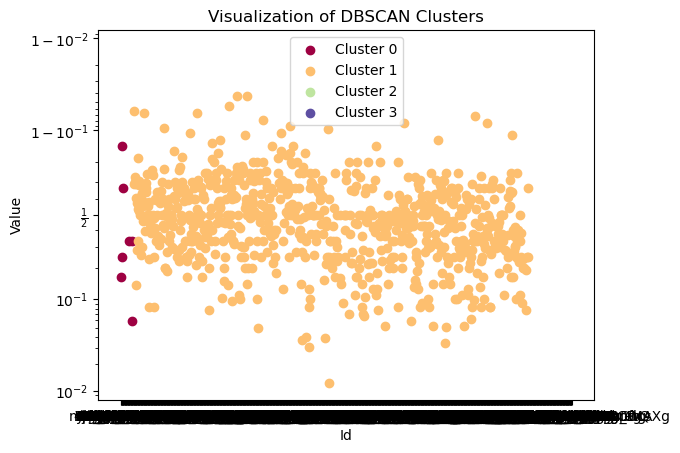

Silhouette Score: 0.29058862547191344
Calinski-Harabasz Score: 128.03481358438447


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


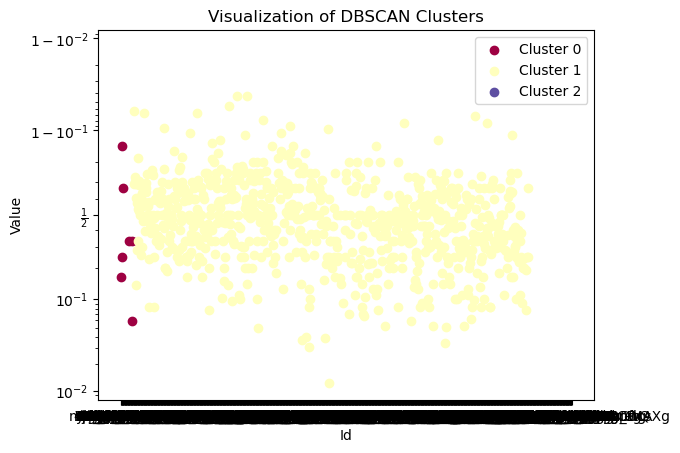

Silhouette Score: 0.29179283363240294
Calinski-Harabasz Score: 134.22409028335386


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


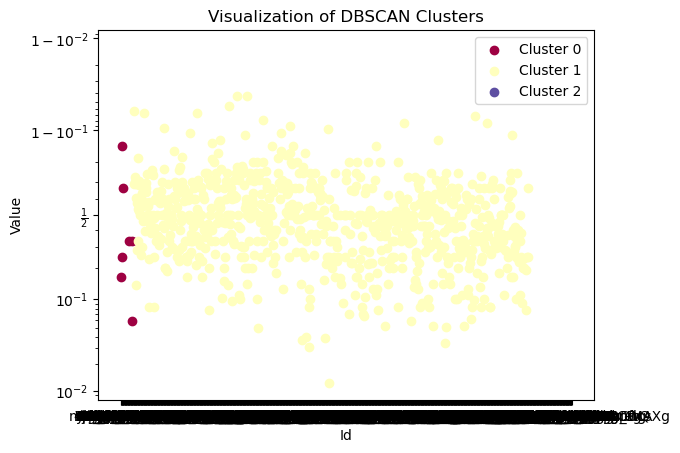

Silhouette Score: 0.2975911272107204
Calinski-Harabasz Score: 143.92267249451248


C:\Users\user\AppData\Local\Temp\ipykernel_10528\49009013.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


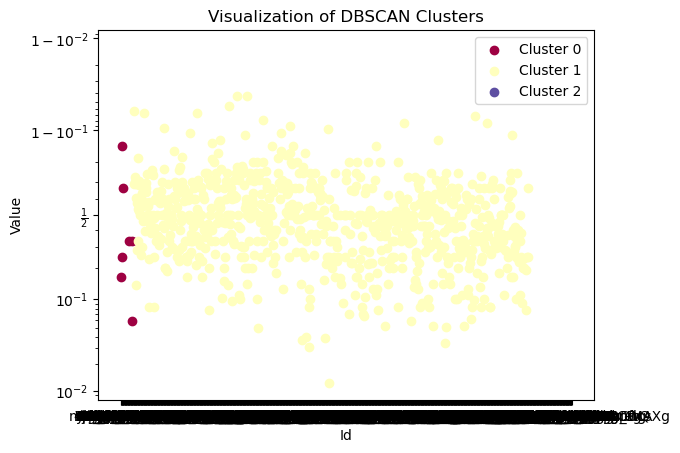

In [1585]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

def dbscan_clustering(data_frame, lst ,eps=0.5, min_samples=10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data_frame.iloc[:, 1:])
    data_frame["cluster_label"] = labels
    silhouette_avg = silhouette_score(data_frame.iloc[:, 1:], labels)
    calinski_harabasz = calinski_harabasz_score(data_frame.iloc[:, 1:], labels)
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    colors = plt.cm.Spectral(np.linspace(0, 1, len(np.unique(labels))))
    for i, cluster_label in enumerate(np.unique(labels)):
        cluster_data = emotions_df[emotions_df['cluster_label'] == cluster_label]
        plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")
    plt.title("Visualization of DBSCAN Clusters")
    plt.xlabel("Id")
    plt.ylabel("Value")
    plt.yscale("logit")
    plt.legend()
    plt.show()
    lst.append((i+1,silhouette_avg,calinski_harabasz))
    return results_lst

    
eps_lst=[0.25,0.5,0.75]
min_samples_lst=[5,10,15]
results_lst=[]
for eps in eps_lst:
    for min_samples in min_samples_lst:
        results_lst = dbscan_clustering(emotions_df.copy(), results_lst, eps, min_samples)


In [1586]:
df_result_DBSCAN= pd.DataFrame(results_lst,columns=['n_clusters','Silhouette','Calinski-Harabasz'])
df_result_DBSCAN

,n_clusters,Silhouette,Calinski-Harabasz
0,11,-0.039630,66.625874
1,9,-0.010979,72.155557
2,5,-0.003063,106.058528
3,5,0.296320,126.361728
4,3,0.325908,277.603429
5,4,0.337226,230.073253
6,3,0.290589,128.034814
7,3,0.291793,134.224090
8,3,0.297591,143.922672


# conclusions
#### The K-MEANS model received the best scores for 3 groups,The hierarchical model also gives a good result for 3 clusters. DBSCAN gave good results for 3 clusters but they were less good than the other models.
#### The grades in the different models are similar, so it is difficult to make a decision on who is the best. We will analyze clustering results for the three models.

# Analysis of Results


### Choosing a division and saving to csv

# THE BEST MODELS

#### K-Means

In [1568]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(emotions_df.iloc[:,1:])
emotions_df["cluster_label"] = kmeans.labels_
clustered_data = emotions_df.groupby("cluster_label")
print(clustered_data.size())

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster_label
0    833
1    174
2    211
dtype: int64


In [1569]:
# Create separate CSV files for Kmeans
for i in range(n_clusters):
    c_data = emotions_df[emotions_df["cluster_label"] == i]
    c_data.to_csv(f'cluster_{i}.csv', index=False)

In [1570]:
c_0_KM = pd.read_csv('cluster_0.csv')
c_1_KM = pd.read_csv('cluster_1.csv')
c_2_KM = pd.read_csv('cluster_2.csv') 


In [1571]:
c_2_KM

,Id,joy,positive,sadness,negative,anger,anticipation,fear,trust,disgust,surprise,cluster_label
0,mLW35YMzELE,0.166667,1.000000,0.500000,0.000000,0.833333,0.000000,0.833333,0.166667,0.000000,0.000000,2
1,3cbnNwxtUUA,0.137931,0.206897,0.206897,1.000000,0.068966,0.000000,0.862069,0.000000,0.034483,0.758621,2
2,t_4ob8SB2UI,0.609756,1.000000,0.487805,0.804878,0.365854,0.560976,0.243902,0.536585,0.000000,0.048780,2
3,pRpeEdMmmQ0,0.333333,0.666667,0.833333,0.833333,0.166667,1.000000,0.333333,0.666667,0.000000,0.000000,2
4,36vjwGx-Vzc,0.000000,0.222222,0.111111,1.000000,0.111111,0.000000,0.111111,0.000000,0.111111,0.888889,2
...,...,...,...,...,...,...,...,...,...,...,...,...
206,iP94Kjrf128,0.000000,1.000000,0.222222,0.888889,0.000000,0.000000,0.888889,0.111111,0.000000,0.000000,2
207,YLDQvDNK_WQ,0.000000,0.000000,0.375000,1.000000,0.500000,0.125000,0.625000,0.125000,0.000000,0.000000,2
208,oIm3m9sgthA,0.076923,1.000000,0.269231,0.576923,0.115385,0.384615,0.461538,0.384615,0.000000,0.153846,2
209,Wwd1sfHSwcQ,0.250000,0.750000,0.000000,1.000000,0.500000,0.250000,0.250000,0.000000,0.000000,0.500000,2


In [1317]:
em_lst={'positive': 'joy positive trust anticipation',
        'negative': 'negative sadness fear anger disgust',
        'surprise': 'surprise'
        }


the word cloud for cluster 0 is: 

frequencies_dict is: Counter({'negative': 17189, 'positive': 15729, 'fear': 11873, 'sadness': 8276, 'anger': 7318, 'anticipation': 7232, 'trust': 6814, 'joy': 4924, 'disgust': 4021, 'surprise': 3472}) 
positive: 34699 negative: 48677 surprise: 3472


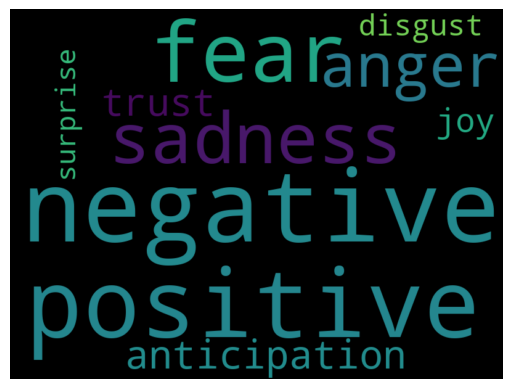

the word cloud for cluster 1 is: 

frequencies_dict is: Counter({'positive': 79360, 'joy': 37622, 'trust': 32405, 'anticipation': 26019, 'sadness': 15333, 'negative': 10815, 'fear': 6537, 'anger': 5896, 'surprise': 5672, 'disgust': 1525}) 
positive: 175406 negative: 40106 surprise: 5672


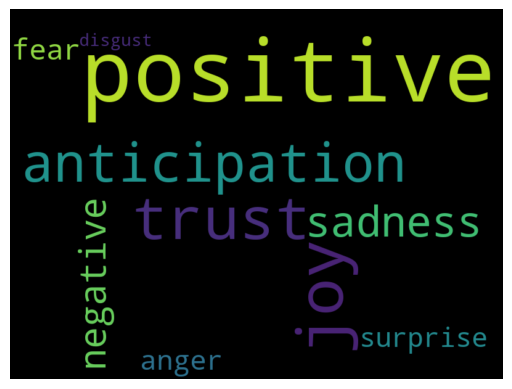

the word cloud for cluster 2 is: 

frequencies_dict is: Counter({'anticipation': 2976, 'sadness': 1052, 'trust': 984, 'negative': 794, 'fear': 760, 'positive': 680, 'joy': 415, 'surprise': 235, 'anger': 179, 'disgust': 125}) 
positive: 5055 negative: 2910 surprise: 235


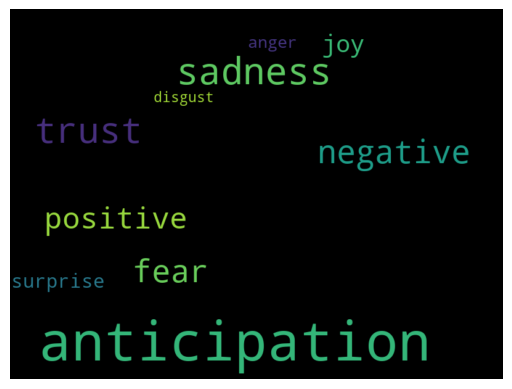

In [1589]:
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

lst_df = [c_0, c_1, c_2] 

scaler = MinMaxScaler()

cluster_num = 0
for cluster in lst_df:
    text = ''
    for col in cluster.iloc[:, 1:-1].columns:
        data_for_scaling = cluster[col].to_numpy().reshape(-1, 1)  
        scaled_data = scaler.fit_transform(data_for_scaling)  
        scaled_values_list = scaled_data.reshape(-1).tolist()
        for value in scaled_values_list:
            text += int(value * 100) * (col + " ") 
    frequencies_dict = Counter(text.split())
    sum_p=0
    sum_neg=0
    sum_n=0
    for key,val in em_lst.items():
        for k,v in frequencies_dict.items():
            if k in em_lst[key] and key == 'positive':
                sum_p += v
            elif k in em_lst[key] and key == 'negative':
                sum_neg += v
            elif k in em_lst[key] and key == 'surprise':
                sum_n+= v
    wordcloud = WordCloud(width=800, height=600, min_word_length = 3, max_words=100, background_color="black") 
    wordcloud_image = wordcloud.generate_from_frequencies(frequencies_dict)
    print("the word cloud for cluster", cluster_num, "is:", '\n\nfrequencies_dict is:', frequencies_dict,"\npositive:",sum_p,'negative:',sum_neg,'surprise:',sum_n)
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    cluster_num += 1


### Cluster 0: Complex Mix of Positive and Negative Emotions
Dominant Emotions: 'negative', 'positive', 'fear', 'sadness', 'anger'
This cluster showcases a complex mixture of emotions. There's a clear presence of negativity, fear, sadness, and anger, but there's also a strong undercurrent of positive sentiment. Videos in this cluster might explore difficult topics, videos that spark debate or controversy, or videos depicting emotionally-charged moments.

### Cluster 1: Predominantly Positive
Dominant Emotions: 'positive', 'joy', 'trust', 'anticipation'
Videos in this cluster seem to convey strong positive emotions, likely expressing enthusiasm, happiness, a sense of trust, and excitement about the content. This cluster might include music videos with upbeat tunes or videos with messages of optimism and h
## Cluster 2: Mixed Emotions with a Lean Towards Sadness
Dominant Emotions: 'anticipation', 'sadness', 'trust', 'negative', 'fear'
This cluster suggests a mix of emotions, with a noticeable presence of sadness and negativity. Some anticipation and trust might suggest underlying hopefulness, while fear adds a touch of apprehension. This cluster could include dramatic movie scenes or videos dealing with loss or difficult life experiences
op

e.


#### Hierarchical clustering

In [1593]:
n_clusters = 3
Z = linkage(emotions_df.iloc[:,1:-1].values, 'ward')
max_d = Z[-1, 2]
threshold = 0.7 * max_d
cluster_assignments = fcluster(Z, threshold, criterion='distance')
emotions_df["cluster_label"] = cluster_assignments
clustered_data = emotions_df.groupby("cluster_label")
print(clustered_data.size())


cluster_label
1    171
2    192
3    855
dtype: int64


In [1594]:
# Create separate CSV files for Hierarchical clustering
for i in range(n_clusters):
    c_data = emotions_df[emotions_df["cluster_label"] == i+1]
    c_data.to_csv(f'cluster_{i}_H.csv', index=False)

In [1596]:
c_0_H = pd.read_csv('cluster_0_H.csv')
c_1_H = pd.read_csv('cluster_1_H.csv')
c_2_H = pd.read_csv('cluster_2_H.csv') 


the word cloud for cluster 0 is: 

frequencies_dict is: Counter({'anticipation': 2558, 'negative': 1457, 'sadness': 1442, 'positive': 965, 'fear': 774, 'joy': 378, 'trust': 348, 'disgust': 328, 'anger': 199, 'surprise': 187}) 
positive: 4249 negative: 4200 surprise: 187


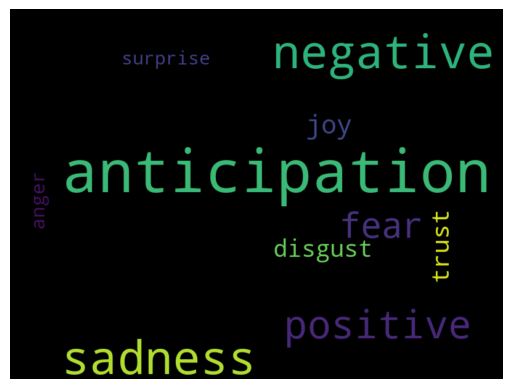

the word cloud for cluster 1 is: 

frequencies_dict is: Counter({'negative': 15801, 'positive': 14543, 'fear': 10992, 'sadness': 7753, 'anger': 6898, 'anticipation': 6665, 'trust': 6211, 'joy': 4831, 'disgust': 3687, 'surprise': 3457}) 
positive: 32250 negative: 45131 surprise: 3457


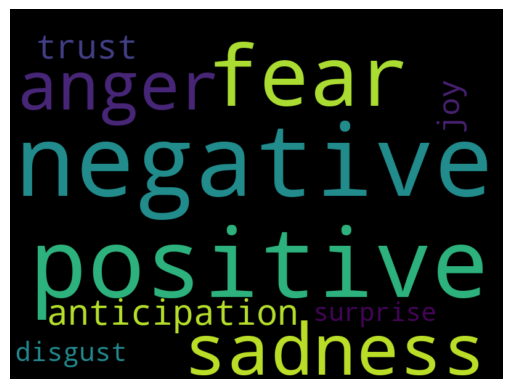

the word cloud for cluster 2 is: 

frequencies_dict is: Counter({'positive': 82008, 'joy': 37745, 'trust': 33808, 'anticipation': 27066, 'sadness': 15467, 'negative': 14422, 'fear': 7409, 'surprise': 5735, 'anger': 4467, 'disgust': 1743}) 
positive: 180627 negative: 43508 surprise: 5735


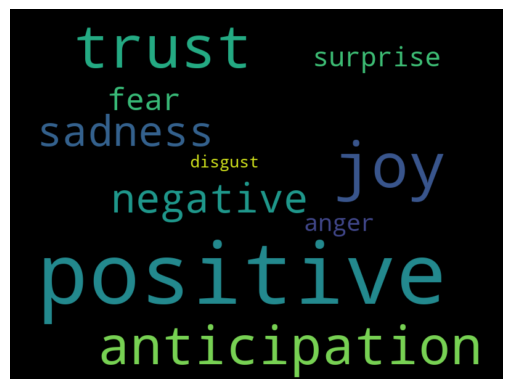

In [1597]:
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

lst_df = [c_0_H, c_1_H, c_2_H] 

scaler = MinMaxScaler()

cluster_num = 0
for cluster in lst_df:
    text = ''
    for col in cluster.iloc[:, 1:-1].columns:
        data_for_scaling = cluster[col].to_numpy().reshape(-1, 1)  
        scaled_data = scaler.fit_transform(data_for_scaling)  
        scaled_values_list = scaled_data.reshape(-1).tolist()
        for value in scaled_values_list:
            text += int(value * 100) * (col + " ") 
    frequencies_dict = Counter(text.split())
    sum_p=0
    sum_neg=0
    sum_n=0
    for key,val in em_lst.items():
        for k,v in frequencies_dict.items():
            if k in em_lst[key] and key == 'positive':
                sum_p += v
            elif k in em_lst[key] and key == 'negative':
                sum_neg += v
            elif k in em_lst[key] and key == 'surprise':
                sum_n+= v
    wordcloud = WordCloud(width=800, height=600, min_word_length = 3, max_words=100, background_color="black") 
    wordcloud_image = wordcloud.generate_from_frequencies(frequencies_dict)
    print("the word cloud for cluster", cluster_num, "is:", '\n\nfrequencies_dict is:', frequencies_dict,"\npositive:",sum_p,'negative:',sum_neg,'surprise:',sum_n)
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    cluster_num += 1


conclution

### Cluster 0: Dominant emotions: Anticipation, negative emotions, sadness
Description: This cluster may indicate content that deals with waiting for something (an album, movie, concert), doubts or anxiety about future events related to music or movies. Sadness may also be prominent, probably due to content dealing with disappointment or criticism.
Word Cloud analysis: Supports the analysis - words with a prominent presence belong to more negative emotions.

### Cluster 1: Dominant emotions: Mixed emotions - mostly negative, with touches of positive. Fear is prominent.
Description: This cluster may contain dramatic, dark, or action-packed content. Videos in this cluster may create feelings of tension, fear, and may include discussions of negative topics.
Word Cloud analysis: Also supports the analysis and the assessment that negative emotions are dominant in the cluster.

### Cluster 2: Dominant emotions: Very positive! Joy, trust, anticipation
Description: This cluster represents positive content, full of joy and hope. It may include videos dealing with optimistic music, happy clips, movies with positive messages, and very good reviews.
Word Cloud analysis: The analysis shows that the high-frequency words belong strongly to positive emotions.


## It can be seen that the clusters are similar in their scores, both in content and in the sizes of the clusters. In fact, the two models reinforce each other.